In [1]:
# Add project src to path.
import set_path
import glob

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
#%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils
import src.utils.bgt_utils as bgt_utils

from src.utils.interpolation import FastGridInterpolator

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks
from src.region_growing.label_connected_comp import LabelConnectedComp

In [2]:
def plot_cloud(points, labels, plot_3d=True):

    fig = plt.figure()
    if plot_3d:
        ax = plt.axes(projection='3d')
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1],points[mask][:,2], s=2, label=str(label))
        ax.set_zlim((0,12))
    else:
        ax = plt.axes()
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1], s=1,label=str(label))
    #plt.legend()
    plt.show()

In [3]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    # Code
    # cable_mask = sample_cable(points, true_labels)
    # armatuur_extractor(points, cable_mask, true_labels)
    

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample6.laz
Processing file ../datasets/suspended_light_cables/sample7.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz
Processing file ../datasets/suspended_light_cables/sample9.laz
Processing file ../datasets/suspended_light_cables/sample8.laz
Processing file ../datasets/suspended_light_cables/sample12.laz
Processing file ../datasets/suspended_light_cables/sample10.laz
Processing file ../datasets/suspended_light_cables/sample11.laz


## Pipeline methods

In [4]:
def main_direction(points):
    """ Returns the eigenvector corresponding to the largest eigenvalue of `points`"""
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    if dir_v[0] < 0:
        dir_v *= -1
    return dir_v

def cable_cut(points, mask):
    """Create a new axis along the direction of a cable. Cable start is 0"""
    cable_dir = main_direction(points[mask][:,:2])
    cable_dir_axis = np.dot(points[:,:2], cable_dir)
    cable_dir_axis -= cable_dir_axis[mask].min()
    return cable_dir_axis

In [5]:
def cable_to_linestrings(points, cable_axis):

    # start and end points
    start_idx = cable_axis.argmin()
    start_pt = [points[start_idx,0], points[start_idx,1]]
    end_idx = cable_axis.argmax()
    end_pt = [points[end_idx,0], points[end_idx,1]]
    
    # cable height LineString (along direction)
    point_spacing = 0.5
    mean_z, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 2], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    xs = np.arange((point_spacing/2), cable_axis.max() - (point_spacing/2), point_spacing)
    line_pts = np.vstack((xs, mean_z)).T
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_ylinestring = shapely.geometry.LineString(line_pts)

    # cable planar LineString
    point_spacing = 1
    mean_x, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 0], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    mean_y, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 1], statistic='mean', bins=np.arange(0, cable_axis.max(), point_spacing))
    line_pts = np.vstack((mean_x, mean_y)).T
    line_pts = np.vstack((line_pts, start_pt, end_pt))
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_axislinestring = shapely.geometry.LineString(line_pts)

    return cable_ylinestring, cable_axislinestring

def clip_cable_area(points, mask, cable_axis, h_buffer=0.5, w_buffer=.5):

    # Cable directional and height line
    cable_yline, cable_axisline = cable_to_linestrings(points[mask], cable_axis[mask])

    # Height clip
    cable_ypoly = cable_yline.buffer(h_buffer)
    dir_points = np.vstack((cable_axis, points[:,2])).T
    height_clip_mask = clip_utils.poly_clip(dir_points, cable_ypoly)

    # Direction clip
    cable_axispoly = cable_axisline.buffer(w_buffer)
    axis_clip_mask = clip_utils.poly_clip(points[:,:2], cable_axispoly)

    # Clip
    clip_mask = np.logical_and(height_clip_mask, axis_clip_mask)

    return clip_mask, cable_yline, cable_axisline


In [6]:
def projection_filter(points, cable_axis):

    # Project
    grid, _, _, binnumber = scipy.stats.binned_statistic_2d(cable_axis, points[:,2], np.ones(len(points)), statistic='count', bins=[np.arange(cable_axis.min(), cable_axis.max(), 0.05), np.arange(points[:,2].min(), points[:,2].max(), 0.05)], expand_binnumbers=True)
    grid_shape = np.array(grid.shape) + 1
    binindices = np.ravel_multi_index(binnumber-1, grid_shape)

    # Image filters
    grid = np.where(grid>0, True, False)
    grid = ndimage.binary_fill_holes(grid)
    grid = ndimage.binary_erosion(grid, iterations=2)
    grid = ndimage.binary_dilation(grid, iterations=3)

    fig = plt.figure()
    ax = plt.axes()
    ax.imshow(grid.T, cmap = 'gray')
    ax.invert_yaxis()

    # convert 2d back to 3d mask
    multi_index = np.array(np.where(grid>0))
    residual_bins = np.ravel_multi_index(multi_index, grid_shape)
    residual_mask = np.isin(binindices, residual_bins)

    return residual_mask

In [7]:
def segmentation_plot(points, cable_axis, segmentation, filter_mask, cable_yline):

    # Plot clusters
    fig = plt.figure()
    ax = plt.axes()
    for cluster in np.unique(segmentation.labels_):
        c_mask = segmentation.labels_ == cluster
        ax.scatter(cable_axis[filter_mask][c_mask], points[filter_mask][c_mask][:,2], s=1)
        ax.scatter(cable_axis[filter_mask][c_mask].mean(), points[filter_mask][c_mask][:,2].mean(), c='k')
    #ax.scatter(cable_axis[filter_mask], points[filter_mask][:,2], s=1)
    ax.scatter(cable_axis[~filter_mask], points[~filter_mask][:,2], s=1, c='gray')

    yline = np.array(cable_yline.coords)
    ax.plot(yline[:,0], yline[:,1], c='k')

    ax.set_ylim((points[:,2].min()-1,points[:,2].max()+1))

In [8]:
def _is_armatuur(points, cable_axis, cable_yline, cable_axisline):

    # Cluster dimension
    cl_width = cable_axis.max() - cable_axis.min()
    cl_height = points[:,2].max() - points[:,2].min()

    # Cluster position offset
    cl_centroid = points.mean(axis=0)
    axis_coord = cable_axis.mean()
    y_offset = nearest_points(cable_yline, Point([axis_coord, cl_centroid[2]]))[0].y - cl_centroid[2]
    axis_offset = LineString(nearest_points(cable_axisline, Point(cl_centroid[:2]))).length

    # Check conditions (1. cluster dimensions & 2. centroid should be under cable)
    width_cond = .25 < cl_width < 1
    height_cond = .2 < cl_height < .55
    yoff_cond = 0 < y_offset < .55
    xyoff_cond = axis_offset < 0.1
    valid_cluster = np.all([width_cond, height_cond, yoff_cond, xyoff_cond])

    record = [axis_coord, cl_width, cl_height, y_offset, axis_offset, valid_cluster]

    return valid_cluster, record


In [9]:
def armatuur_extractor(points, cable_mask, true_labels):

    # 0. create mask
    armatuur_mask = np.zeros(len(points), dtype=bool)

    # 1. Clip search-area
    cable_axis = cable_cut(points, cable_mask)
    clip_mask, cable_yline, cable_axisline = clip_cable_area(points, cable_mask, cable_axis)
    plot_cloud(points[clip_mask], true_labels[clip_mask])

    # 2. Projection
    filter_mask = projection_filter(points[clip_mask], cable_axis[clip_mask])

    # 3. Clustering/Segmentation
    segmentation = (DBSCAN(eps=0.25, min_samples=4, p=2).fit(points[clip_mask][filter_mask]))
    segmentation_plot(points[clip_mask], cable_axis[clip_mask], segmentation, filter_mask, cable_yline)

    # 4. Cluster analysis for armatuur
    for cluster in np.unique(segmentation.labels_):
        c_mask = segmentation.labels_ == cluster
        cl_pts = points[clip_mask][filter_mask][c_mask]
        cl_axis_pts = cable_axis[clip_mask][filter_mask][c_mask]
        valid, _ = _is_armatuur(cl_pts, cl_axis_pts, cable_yline, cable_axisline)

        print(cl_pts.mean(axis=0))

        # TODO: create new mask for armatuur
        # ? BoundingBox
        # ? LCC
        cl_ids = np.where(clip_mask)[0][filter_mask][c_mask]
        armatuur_mask[cl_ids] = valid

    plot_cloud(points[clip_mask], armatuur_mask[clip_mask])

In [10]:
def sample_cable(points, true_labels, sample_size=0.8):
    cable_ids = np.where(true_labels==15)[0]
    cable_sample_ids = np.random.choice(cable_ids, int(len(cable_ids)*(1-sample_size)), replace=False)
    sample_labels = true_labels.copy()
    sample_labels[cable_sample_ids] = 0
    cable_mask = sample_labels == 15

    return cable_mask

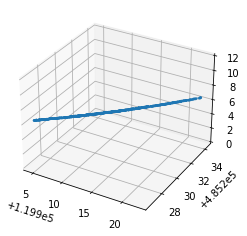

In [11]:
pointcloud = las_utils.read_las('../datasets/suspended_light_cables/sample10.laz')
true_labels = pointcloud.label
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = np.zeros(len(points))

cable_mask = sample_cable(points, true_labels)
plot_cloud(points[cable_mask], true_labels[cable_mask])

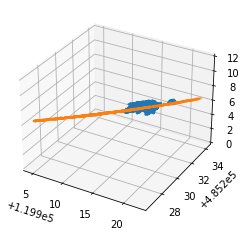

[1.19915843e+05 4.85231318e+05 6.28527082e+00]
[1.19918796e+05 4.85233021e+05 6.13540659e+00]


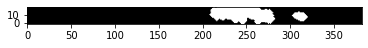

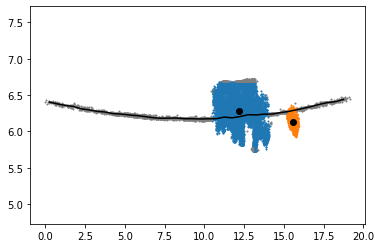

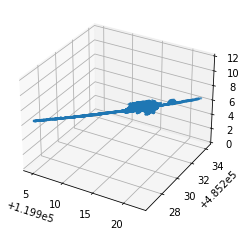

In [12]:
armatuur_extractor(points, cable_mask, true_labels)

## Approach: LCC

In [11]:
pointcloud = las_utils.read_las('../datasets/suspended_light_cables/sample12.laz')
true_labels = pointcloud.label
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = np.zeros(len(points))

cable_mask = sample_cable(points, true_labels, .99)
cable_mask = true_labels == 15
# plot_cloud(points[cable_mask], true_labels[cable_mask])

In [12]:
cable_axis = cable_cut(points, cable_mask)
clip_mask, cable_yline, cable_axisline = clip_cable_area(points, cable_mask, cable_axis)

new_labels = np.zeros(len(true_labels))
new_labels[cable_mask] = 15

# plot_cloud(points[clip_mask], new_labels[clip_mask])

In [13]:
# TODO: clip the cable out

lcc = LabelConnectedComp(label=-1, grid_size=0.1, min_component_size=50, exclude_labels=[15])
lcc_mask = lcc.get_components(points[clip_mask], new_labels[clip_mask])
free_mask = new_labels[clip_mask] != 15
free_ids = np.where(clip_mask)[0][free_mask]
new_labels[free_ids] = lcc_mask

# 4. Cluster analysis for armatuur
for label in set(new_labels).difference(set([-1,0,15])):
    c_mask = new_labels == label
    cl_pts = points[c_mask]
    cl_axis_pts = cable_axis[c_mask]
    valid, _ = _is_armatuur(cl_pts, cl_axis_pts, cable_yline, cable_axisline)
    print(label, valid)

plot_cloud(points[clip_mask], new_labels[clip_mask])

1.0 True
2.0 True
4.0 False


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Aproach:
Cable-density


In [11]:
def cable_density(points, labels, plot=True):

    # Projection axis
    cable_mask = labels == 15
    cable_dir_axis = cable_cut(points, cable_mask)

    res = scipy.stats.binned_statistic(cable_dir_axis, np.ones(len(points)), statistic='count', bins=int(cable_dir_axis.max()/0.1))
    x = (res.bin_edges[:-1]+res.bin_edges[1:])/2
    y = res.statistic / len(points)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(x, y)

Processing file ../datasets/suspended_light_cables/sample1.laz


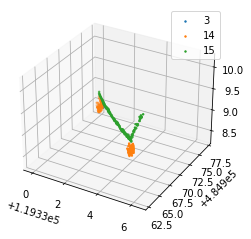

Processing file ../datasets/suspended_light_cables/sample3.laz


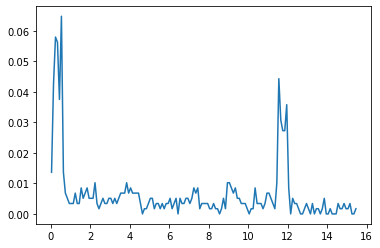

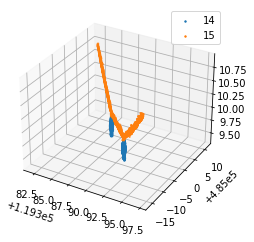

Processing file ../datasets/suspended_light_cables/sample2.laz


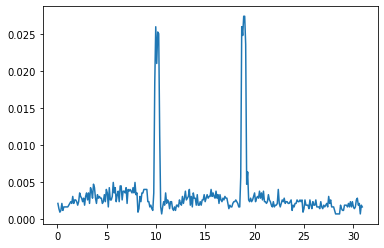

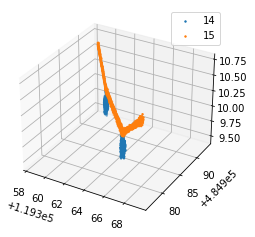

Processing file ../datasets/suspended_light_cables/sample5.laz


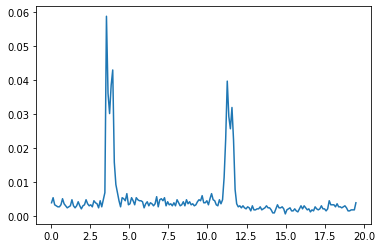

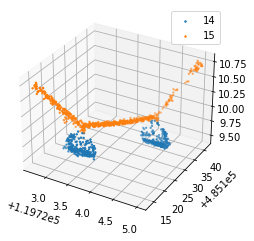

Processing file ../datasets/suspended_light_cables/sample4.laz


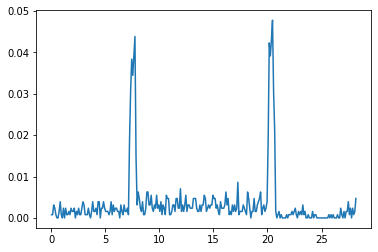

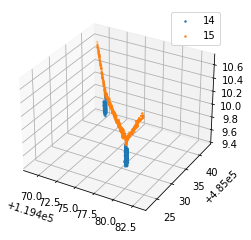

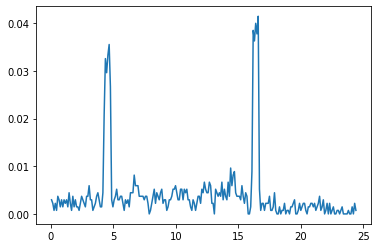

In [342]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    plot_cloud(points, true_labels)
    cable_density(points, true_labels)

## Approach: 
Cable-bending

In [9]:
def unit_vector(v1):
    """ Returns the unit vector of `v1`"""
    return v1 / np.linalg.norm(v1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [10]:
def cable_angle(points, labels, plot=True):

    cable_mask = labels == 15
    lamp_mask = labels == 14

    # Calculate directional axis
    cable_dir_axis = cable_cut(points, cable_mask)

    # cable height LineString (along direction)
    mean_z, _, _ = scipy.stats.binned_statistic(cable_dir_axis[cable_mask], points[cable_mask][:, 2], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 0.5))
    xs = np.arange(0.25, cable_dir_axis.max()-0.25, 0.5)
    ls_poitns = np.vstack((xs, mean_z)).T
    cable_height_linestring = shapely.geometry.LineString(ls_poitns)

    # Calculate angle change
    color_v = []
    for i in range(len(ls_poitns)):
        if i < 5 or i > len(ls_poitns) - 6:
            color_v.append(0.)
        else:
            v_a = ls_poitns[i] - ls_poitns[i-5]
            v_b = ls_poitns[i+5] - ls_poitns[i]
            angle = angle_between(v_a, v_b)
            color_v.append(angle)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(xs, mean_z, s=4, c=color_v, cmap='Reds_r')
        ax.scatter(cable_dir_axis[lamp_mask], points[lamp_mask,2], s=2)

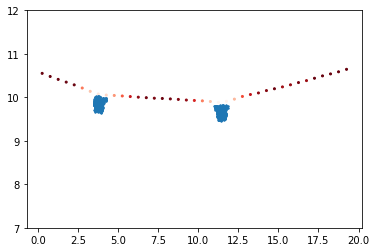

In [337]:
cable_angle(points, true_labels)

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz


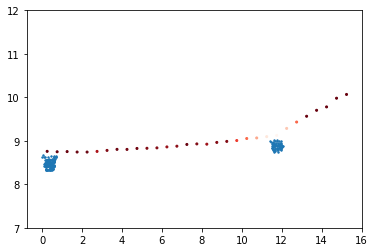

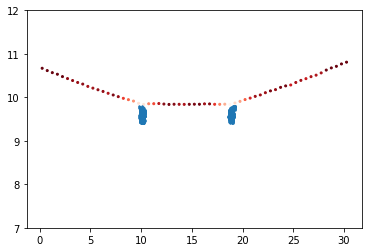

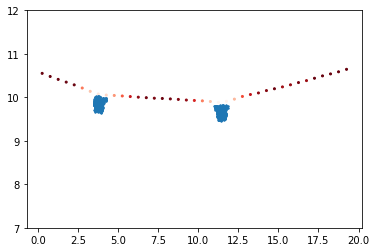

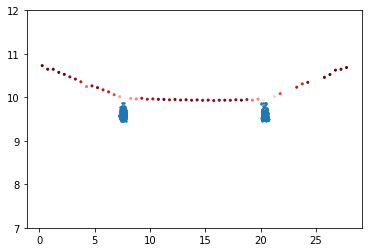

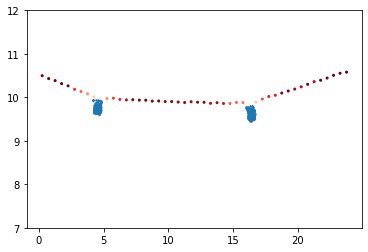

In [338]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    cable_angle(points, true_labels)